quandl housing api:  
https://www.quandl.com/blog/api-for-housing-data

api key:  
11Uh5euqzE625yn6n5QG

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT

sns.set_context("paper")

In [4]:
hoods = ut.load_hoods()
cities = ut.load_cities()
counties = ut.load_counties()
indicators = ut.load_indicators()

preview

In [5]:
indicators.head()

,Indicator Name,Indicator Code
0,All Homes,A
1,Single Family Residences,SF
2,Condominiums,C
3,Price per Square Foot,MVSF
4,1 Bedroom,1B


build cities sale price df

In [6]:
px = ut.load_quandl_data('hoods','A')

In [7]:
px.shape

(233, 824)

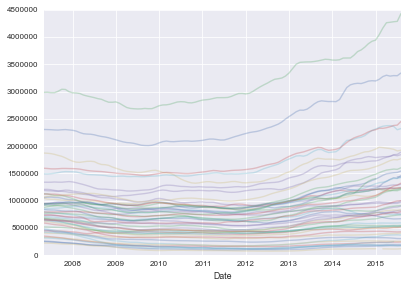

In [8]:
px.ix[-100:,-50:].plot(alpha=.3, legend=False)

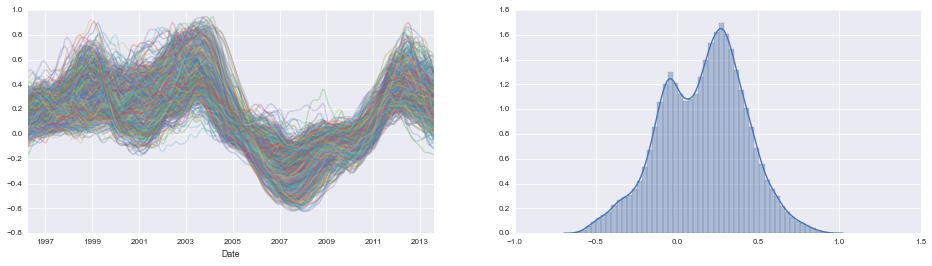

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
fwd_ret = ut.get_forward_return(px, periods=RET_PER)
fwd_ret.plot(legend=False, alpha=.3, ax=axes[0])
sns.distplot(fwd_ret.stack())

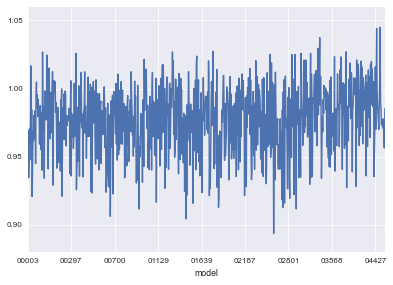

In [72]:
ca = pd.read_csv('data/api_data/a_ca.csv', parse_dates='Date', index_col='Date')['Value']
betas = get_betas(px, ca, per=RET_PER)
betas.plot()

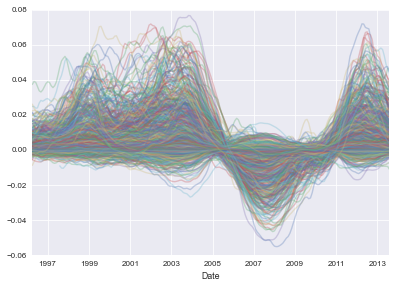

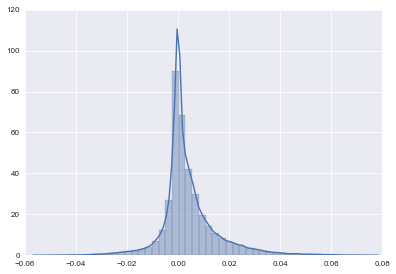

In [69]:
fwd_ret_nt = (fwd_ret - (fwd_ret * betas))
fwd_ret_nt.plot(legend=False, alpha=.3)
plt.figure()
sns.distplot(fwd_ret_nt.stack())

In [73]:
corr = ut.lead_lag_corr(px, fwd_ret_nt)
corr.plot(kind='bar', title='full period')

TypeError: stack_and_align() got multiple values for keyword argument 'cols'

{'f_test': None,
 'params': array([ 0.07442369]),
 'tvalues': array([ 232.58348514])}

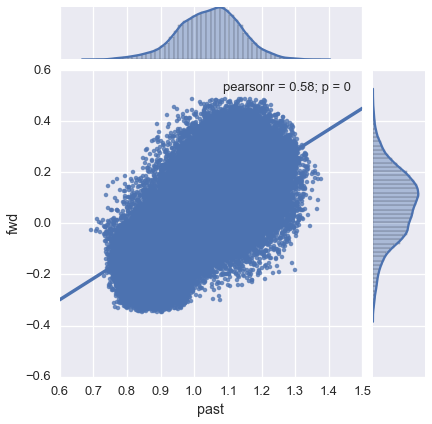

In [9]:
r = (px / px.shift(8))
df = pd.concat([r.stack().to_frame(), fwd_ret.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

{'f_test': None,
 'params': array([ 0.06792381]),
 'tvalues': array([ 227.6450317])}

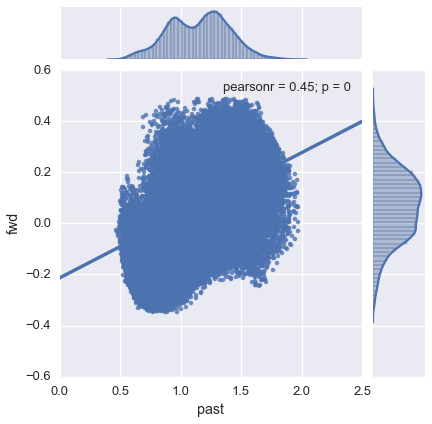

In [10]:
r = (px / px.shift(24))
df = pd.concat([r.stack().to_frame(), fwd_ret.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

{'f_test': None,
 'params': array([-0.01169843]),
 'tvalues': array([-49.42752879])}

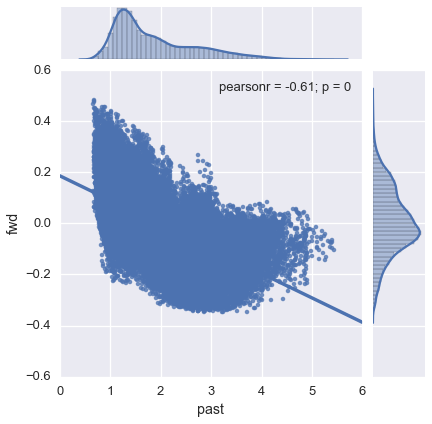

In [11]:
r = (px / px.shift(120))
df = pd.concat([r.stack().to_frame(), fwd_ret.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

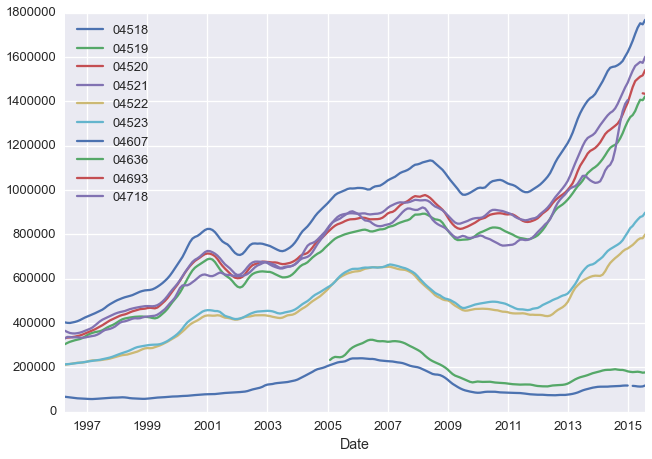

In [12]:
px.ix[:,-10:].plot()

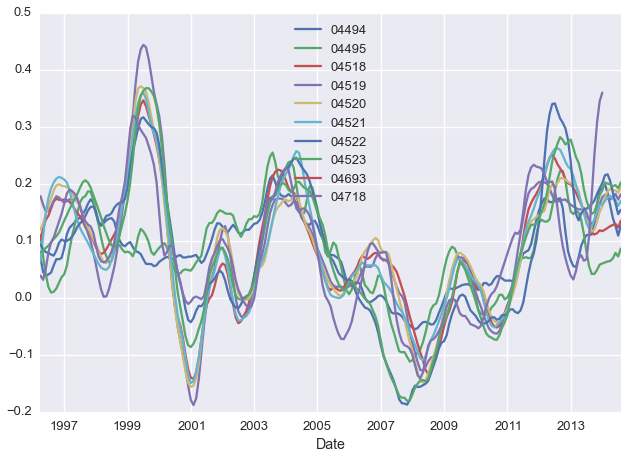

In [13]:
fwd_ret.ix[:,-10:].plot()

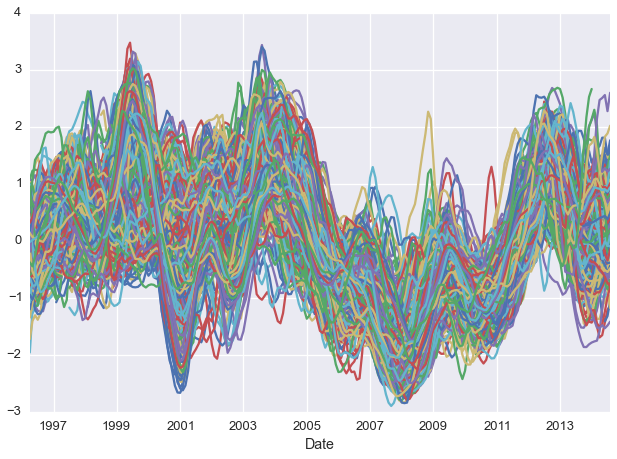

In [14]:
fwd_ret_ts = ut.ts_score(fwd_ret)
fwd_ret_ts.plot(legend=False)

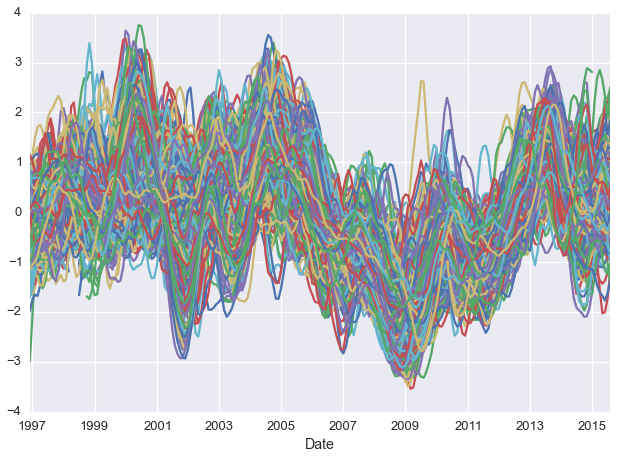

In [15]:
mom = ut.ts_score((px / px.shift(8)).dropna(how='all'))
mom.plot(legend=False)

In [16]:
df = ut.stack_and_align(mom, fwd_ret_ts, cols=['mom', 'fwd'])

In [17]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(df[['mom']], df['fwd'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
pred_score = pd.DataFrame(clf.predict(df[['mom']]), index=df.index, columns=['pred_score'])
pred_value = ut.z_score_to_value(df['mom'].unstack(), fwd_ret).stack()
pred_value.name = 'pred_value'
d = ut.stack_and_align([df['mom'], df['fwd'], pred_score, pred_value])
d['pred_err'] = df['fwd'] - pred_value
a = d[['fwd', 'pred_value']].applymap(lambda x: 1 if x > 0 else -1)
d['dir_accurate'] = a['fwd'] == a['pred_value']

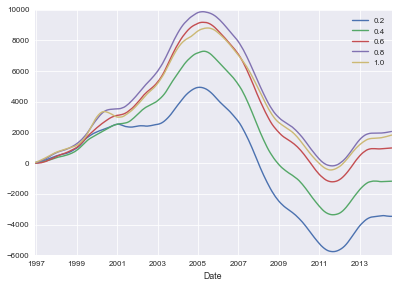

In [139]:
ut.gen_quintile_data(d, 'pred_score', 'fwd').cumsum().plot()

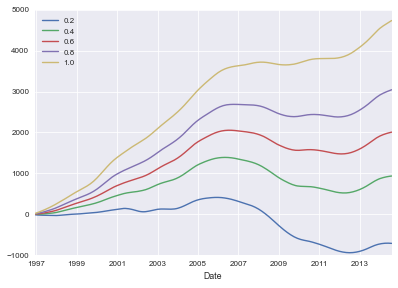

In [140]:
ut.gen_quintile_data(d, 'pred_score', 'pred_value').cumsum().plot()

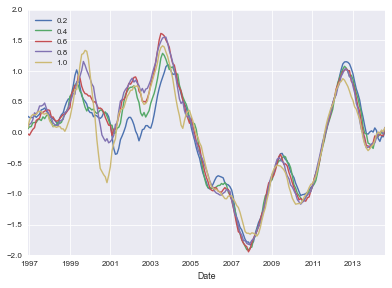

In [141]:
ut.gen_quintile_data(d, 'pred_score', 'pred_err', agg='mean').plot()

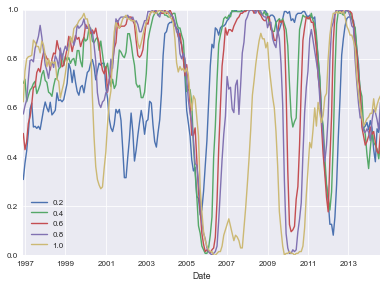

In [150]:
ut.gen_quintile_data(d, 'pred_score', 'dir_accurate', agg='mean').plot()

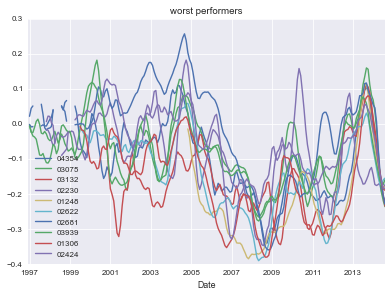

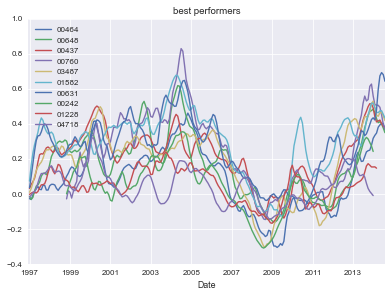

In [175]:
c = ut.get_cum_return(d['pred_value'].unstack(), outlier_threshold=10)
assets_ranked = c.tail(5).mean().order().index
c[assets_ranked[:10]].plot(title='worst performers')
c[assets_ranked[-10:]].plot(title='best performers')

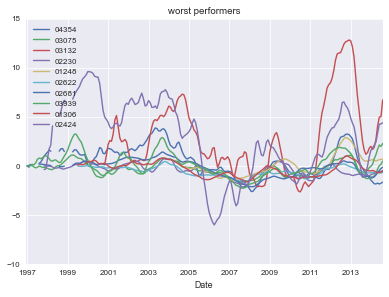

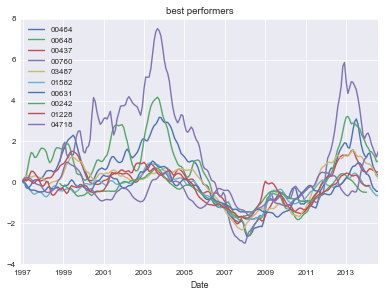

In [176]:
c = ut.get_cum_return(d['fwd'].unstack(), outlier_threshold=10)
c[assets_ranked[:10]].plot(title='worst performers')
c[assets_ranked[-10:]].plot(title='best performers')